# **Assessment 2**

For our second assessment, we will be looking at sequential weather data. The data contains a number of relevant weather variables, recorded daily for a European city during a period of four decades.

However, this dataset has been corrupted, and some of the daily measurements are now missing. The goal of this assessment is to develop a neural network architecture that can recover the missing measurements!

<br>

---

<br>

The dataset has been saved as `.csv` files and has been separated into a `training_set/` folder and a `test_set.csv` file. The `training_set/` contains data for three of the four decades, separated in one individual file per decade:

- `training_set_0.csv` contains corrupted data for the first decade; `training_set_0_nogaps.csv` contains the same data before it was corrupted.
- `training_set_1.csv` contains corrupted data for the second decade; `training_set_1_nogaps.csv` contains the same data before it was corrupted.
- `training_set_2.csv` contains corrupted data for the third decade; `training_set_2_nogaps.csv` contains the same data before it was corrupted.

The `test_set.csv` file contains the remaining decade; this data is corrupted and contains gaps, but we have lost access to the data before corruption.

The architecture that you design in this assessment should use the data contained inside the `training_set` in order to recover the missing information in the data in `test_set.csv`. Note that decades `0`, `1`, and `2` are not necessarily consecutive.

Inside each of the `.csv` files, you will find the following columns:

- `date`
- `cloud_cover`
- `sunshine`
- `global_radiation`
- `max_temp`
- `mean_temp`
- `min_temp`
- `precipitation`
- `pressure`

<br>

All answers to the assessment should be contained within the structure below, but you are free to add new code and text cells as required to your answers. Read the text for each question and follow the instructions carefully. Answers that do not follow this structure will not be marked. **Do NOT change the name of this file.**

Please, **make sure to execute all your cells and save the result of the execution**. We will only mark cells that have been executed and will not execute any cells ourselves.

<br>

---

<br>

<br><br>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn


In [ ]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
except:
  pass

Mounted at /content/drive


In [ ]:
def set_device(device="cpu", idx=0):
    if device != "cpu":
        if torch.cuda.device_count() > idx and torch.cuda.is_available():
            print("Cuda installed! Running on GPU {} {}!".format(idx, torch.cuda.get_device_name(idx)))
            device="cuda:{}".format(idx)
        elif torch.cuda.device_count() > 0 and torch.cuda.is_available():
            print("Cuda installed but only {} GPU(s) available! Running on GPU 0 {}!".format(torch.cuda.device_count(), torch.cuda.get_device_name()))
            device="cuda:0"
        else:
            device="cpu"
            print("No GPU available! Running on CPU")
    return device

device = set_device("cuda")

Cuda installed! Running on GPU 0 NVIDIA A100-SXM4-40GB!


## **Question 1**  (25%)

Load the training and test datasets. Then, use the space below to present the following set of figures:

1. Using line plots, show the different variables in each dataset, both before and after corruption. Choose a single decade to plot, and plot the first 365 days of data. Plot the time series for each variable in an independent axis window. Make sure the axis windows are sized appropriately so that trends and corruption in the variables can be easily observed.
2. Plot a histogram for each variable in each dataset, across all decades, both before and after corruption.

<br>

First, let's load all the CSV files present in the repository.

In [ ]:
train0_corr = pd.read_csv('training_set_0.csv').set_index('date')
train0_uncorr = pd.read_csv('training_set_0_nogaps.csv').set_index('date')
train1_corr = pd.read_csv('training_set_1.csv').set_index('date')
train1_uncorr = pd.read_csv('training_set_1_nogaps.csv').set_index('date')
train2_corr = pd.read_csv('training_set_2.csv').set_index('date')
train2_uncorr = pd.read_csv('training_set_2_nogaps.csv').set_index('date')
test_df = pd.read_csv('test_set.csv').set_index('date')
train2_uncorr.head()

,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure
date,,,,,,,,
0,2.1,6.2,46.5,4.6,1.6,-1.1,-0.0,100586.4
1,4.0,5.8,41.8,2.6,1.3,-2.2,0.0,101535.8
2,1.9,4.3,35.4,1.5,1.0,-0.6,0.0,102314.0
3,0.0,6.5,55.0,1.8,-1.9,-5.9,0.2,101986.6
4,7.0,0.0,15.5,1.2,-1.9,-5.7,2.0,100515.9


This function allows us to plot the first 365 days of the chosen decade (in our case, we chose decade 0) for both the corrupted and uncorrupted DataFrames, as well as for the first year of the test set. Instead of creating one large plot with all the subplots, I decided to create a separate cell for each variable, providing better visualization. We will see that for the corrupted data, the missing values are usually successive, meaning that the days with missing values are consecutive, as opposed to being randomly scattered.

In [ ]:
def plot_variable_comparison(corrupted_df, uncorrupted_df,test_df, variable, figsize=(10, 5)):
    number_of_corr = corrupted_df[:365][variable].isnull().sum()
    print(f"For the first 365 days, the number of days where there are missing values for {variable} is {number_of_corr}")

    plt.figure(figsize=figsize)

    plt.subplot(3, 1, 1)
    plt.plot(corrupted_df[variable][:365])
    plt.title(f'Corrupted Train {variable.capitalize()}')
    plt.xlabel('Days')
    plt.ylabel(variable.capitalize())

    plt.subplot(3, 1, 2)
    plt.plot(uncorrupted_df[variable][:365])
    plt.title(f'Uncorrupted Train {variable.capitalize()}')
    plt.xlabel('Days')
    plt.ylabel(variable.capitalize())

    plt.subplot(3, 1, 3)
    plt.plot(test_df[variable][:365])
    plt.title(f'Corrupted Test {variable.capitalize()}')
    plt.xlabel('Days')
    plt.ylabel(variable.capitalize())


    plt.tight_layout()
    plt.show()


**Cloud_cover**

For the first 365 days, the number of days where there are missing values for cloud_cover is 91


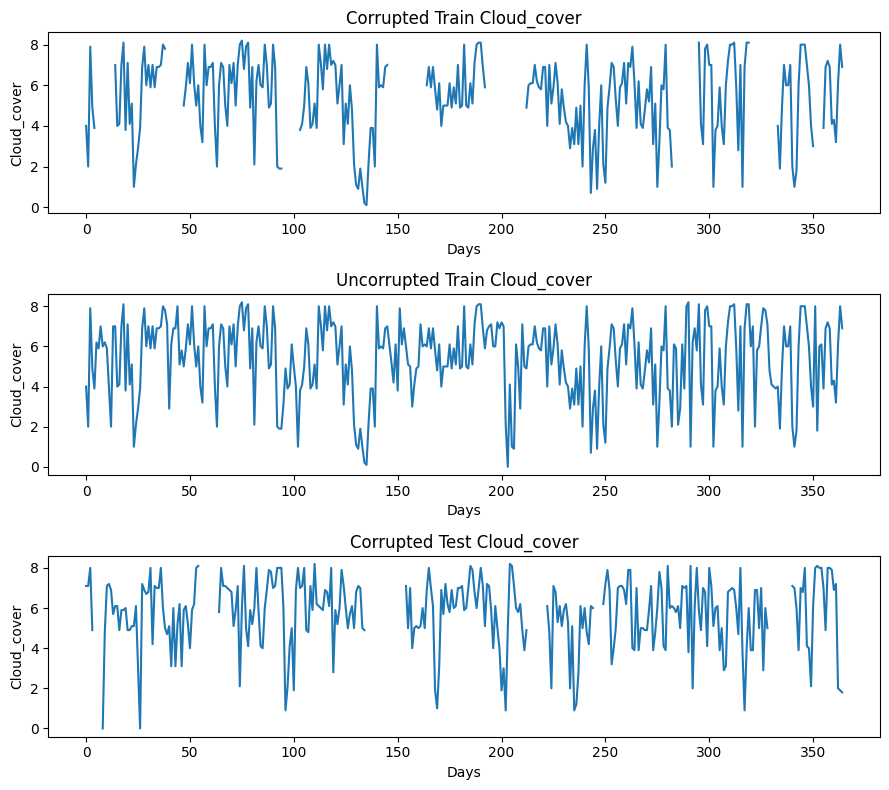

In [ ]:
plot_variable_comparison(train0_corr, train0_uncorr,test_df, 'cloud_cover', figsize=(9, 8))

**Sunshine**

For the first 365 days, the number of days where there are missing values for sunshine is 67


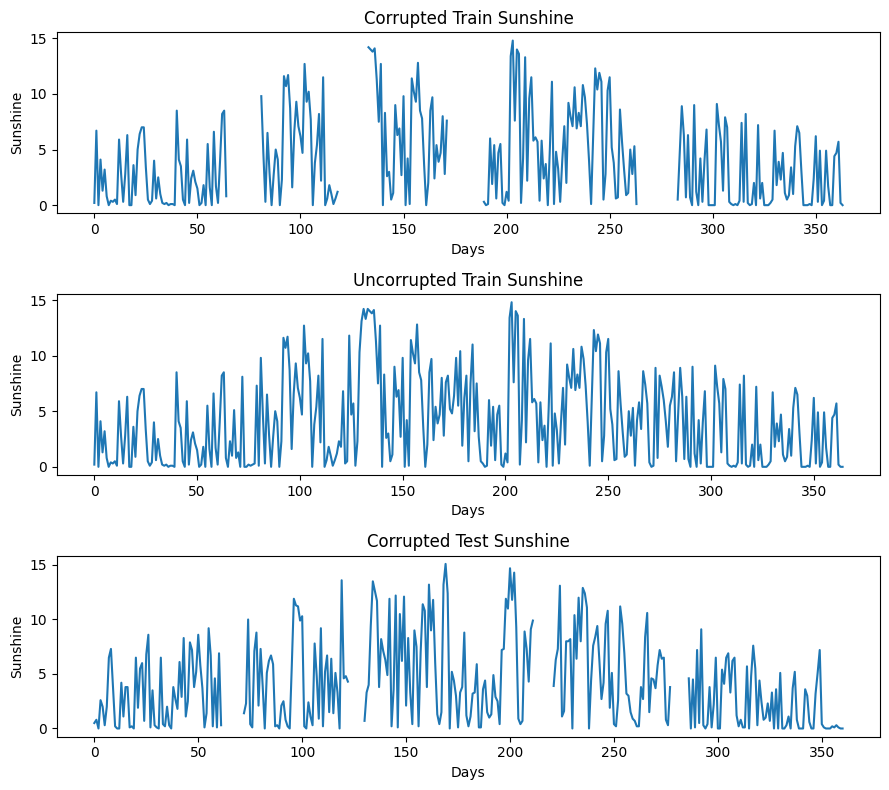

In [ ]:
plot_variable_comparison(train0_corr, train0_uncorr,test_df, 'sunshine', figsize=(9,8))

**global_radiation**

For the first 365 days, the number of days where there are missing values for global_radiation is 62


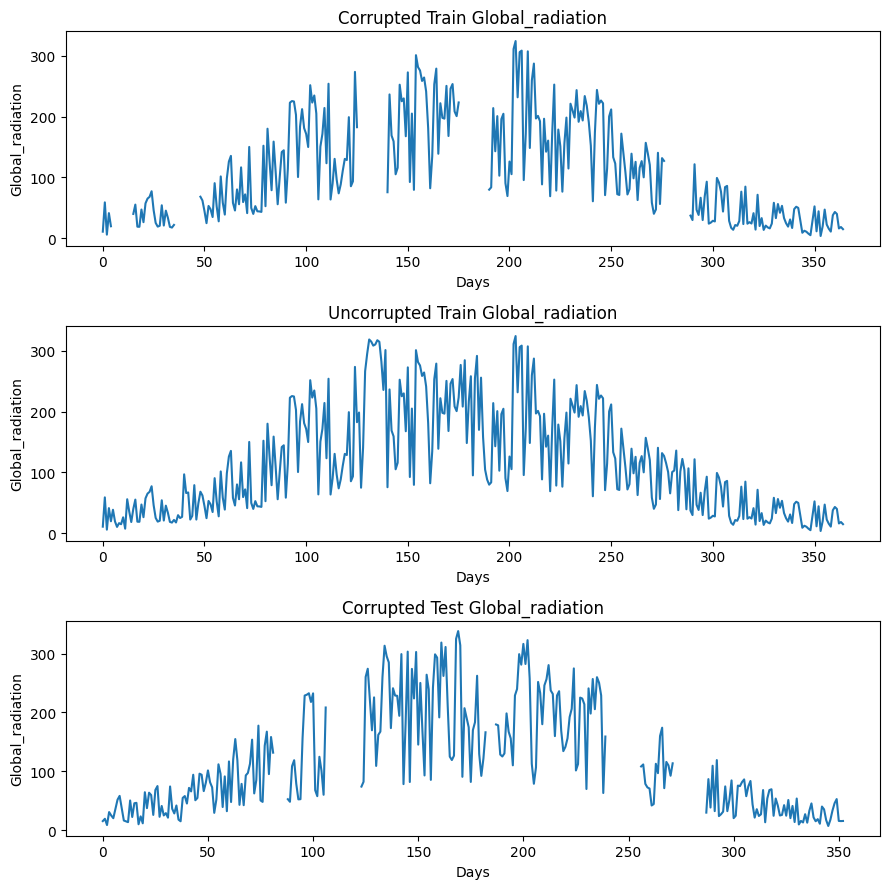

In [ ]:
plot_variable_comparison(train0_corr, train0_uncorr,test_df, 'global_radiation', figsize=(9,9))

**max_temp**

For the first 365 days, the number of days where there are missing values for max_temp is 62


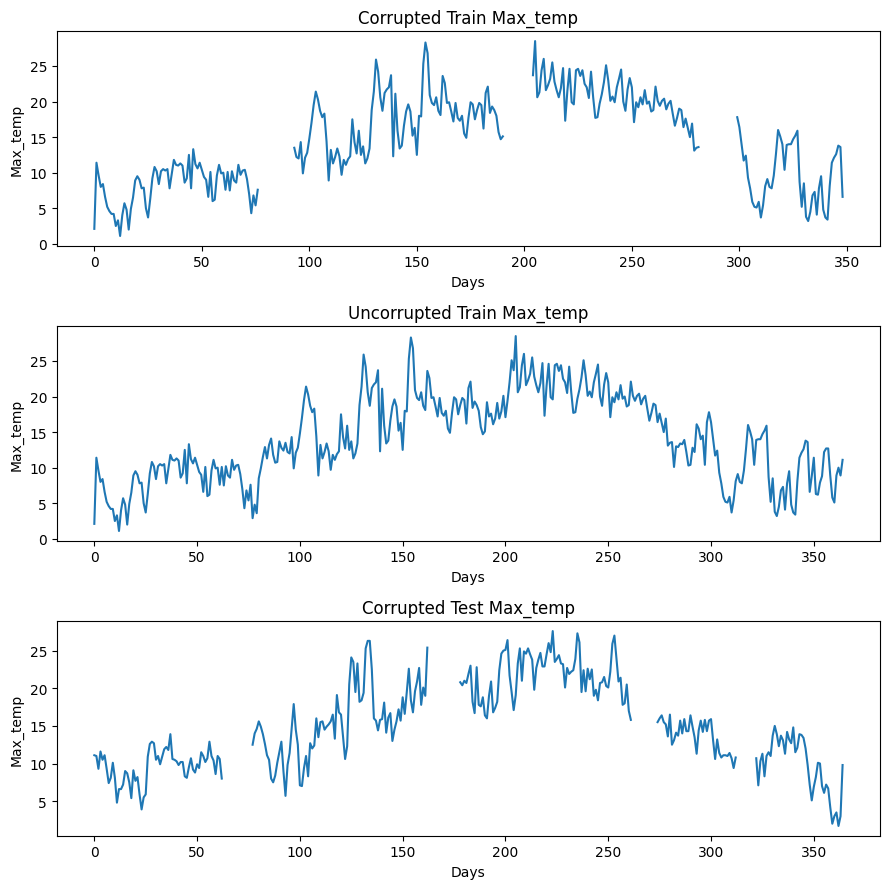

In [ ]:
plot_variable_comparison(train0_corr, train0_uncorr, test_df, 'max_temp', figsize=(9, 9))

**mean_temp**

For the first 365 days, the number of days where there are missing values for mean_temp is 78


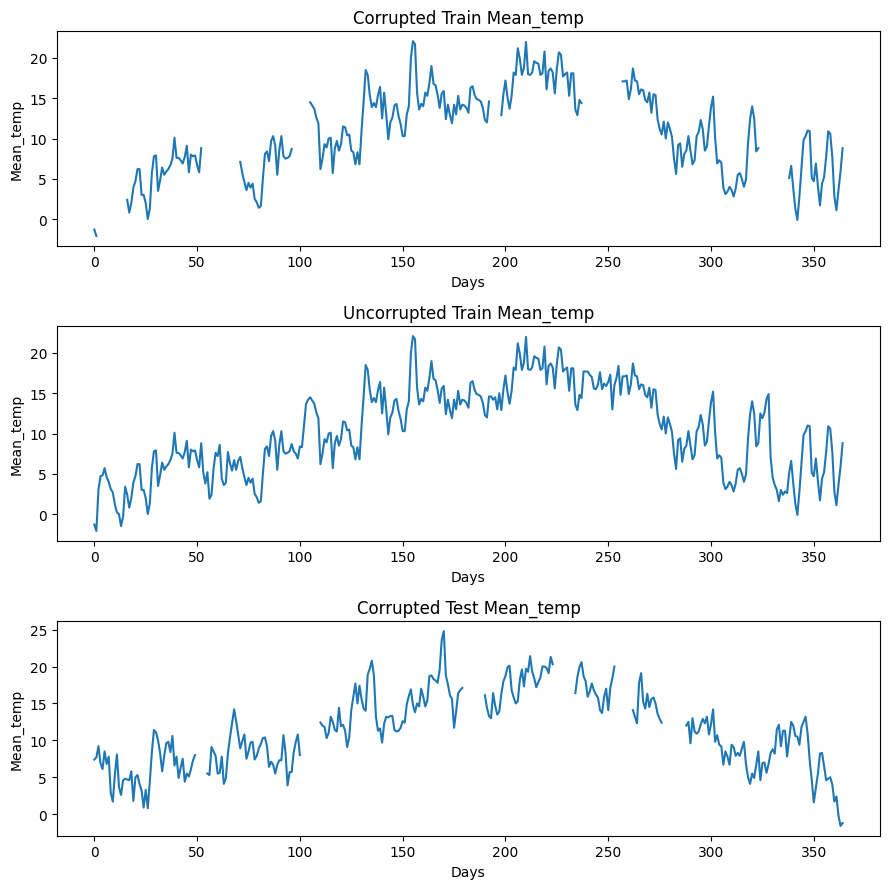

In [ ]:
plot_variable_comparison(train0_corr, train0_uncorr, test_df,'mean_temp', figsize=(9,9))

**min_temp**

For the first 365 days, the number of days where there are missing values for min_temp is 81


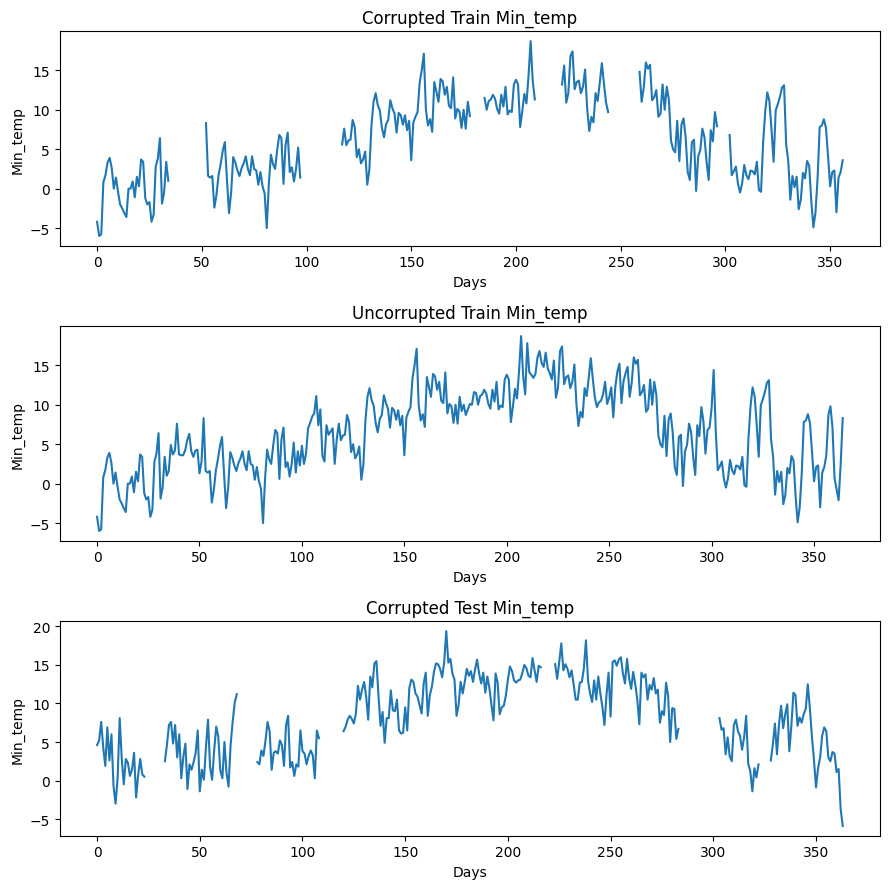

In [ ]:
plot_variable_comparison(train0_corr, train0_uncorr, test_df, 'min_temp', figsize=(9, 9))

**precipitation**

For the first 365 days, the number of days where there are missing values for precipitation is 39


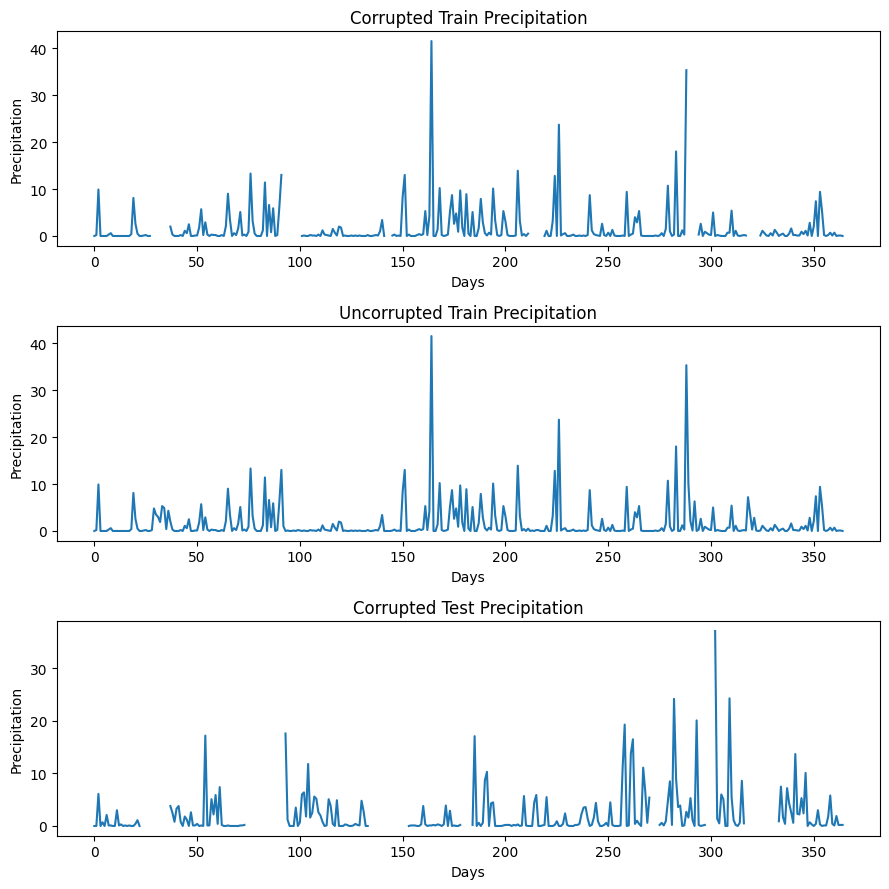

In [ ]:
plot_variable_comparison(train0_corr, train0_uncorr, test_df, 'precipitation', figsize=(9, 9))

**pressure**

For the first 365 days, the number of days where there are missing values for pressure is 64


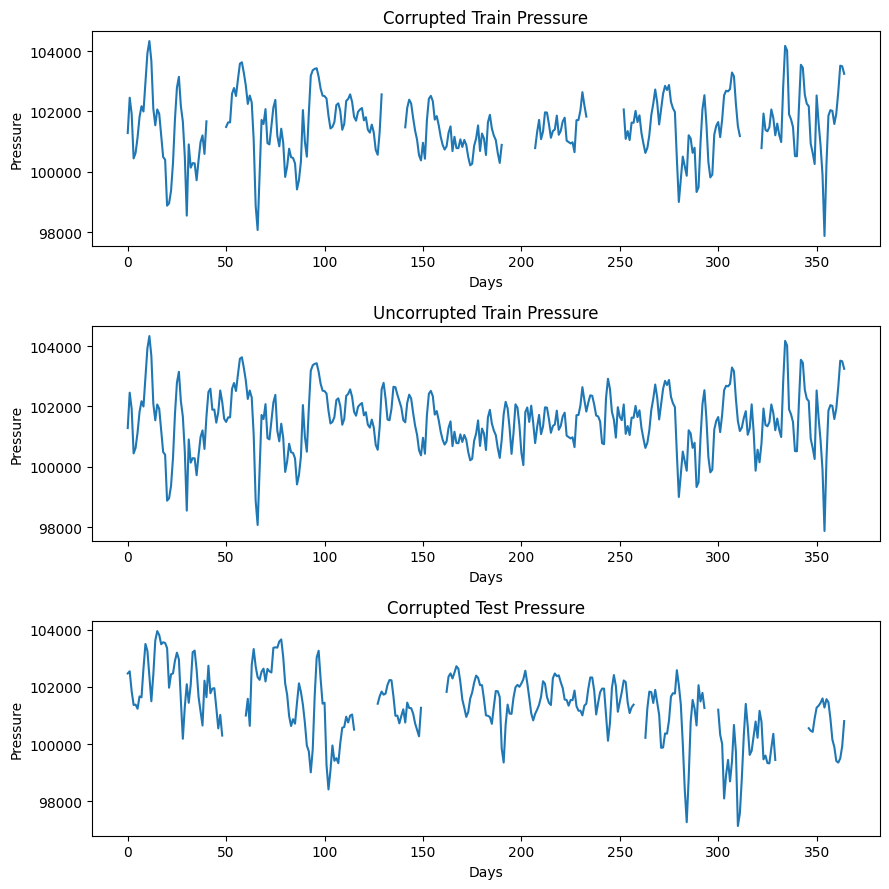

In [ ]:
plot_variable_comparison(train0_corr, train0_uncorr, test_df, 'pressure', figsize=(9, 9))

We will now plot a histogram for each variable. Once again, for visual purposes, I will create one cell for each variable to gain a better understanding of the distribution. This can be helpful for data preprocessing during hyperparameter tuning, as I can apply a specific scaler for each variable based on its distribution.

Here, I decided to concatenate all the decades together. Even though we do not have knowledge regarding the chronological order, the fact that we are plotting histograms means that chronological order does not impact the distribution, as we are looking at the number of occurrences of a specific value.

Additionally, we are comparing the corrupted_decades and uncorrupted_decades with the test_df, which does not have the same length (approximately three times smaller). Since we are plotting histograms, it is helpful to see the overall trend; therefore, the length does not significantly impact the distribution on this scale.

In [ ]:
corrupted_decades = pd.concat([train0_corr,train1_corr,train2_corr])
uncorrupted_decades = pd.concat([train0_uncorr,train1_uncorr,train2_uncorr])
print(len(corrupted_decades),len(uncorrupted_decades),len(test_df))

10954 10954 3652


In [ ]:
def plot_variable_histograms(corrupted_df, uncorrupted_df, test_df, variable, figsize=(9, 9)):
    plt.figure(figsize=figsize)

    plt.subplot(3, 1, 1)
    sns.histplot(corrupted_df[variable], bins=30, kde=True)
    plt.title(f'Corrupted Train {variable.capitalize()}')

    plt.subplot(3, 1, 2)
    sns.histplot(uncorrupted_df[variable], bins=30, kde=True)
    plt.title(f'Uncorrupted Train {variable.capitalize()}')

    plt.subplot(3, 1, 3)
    sns.histplot(test_df[variable], bins=30, kde=True)
    plt.title(f'Corrupted Test {variable.capitalize()}')

    plt.tight_layout()
    plt.show()

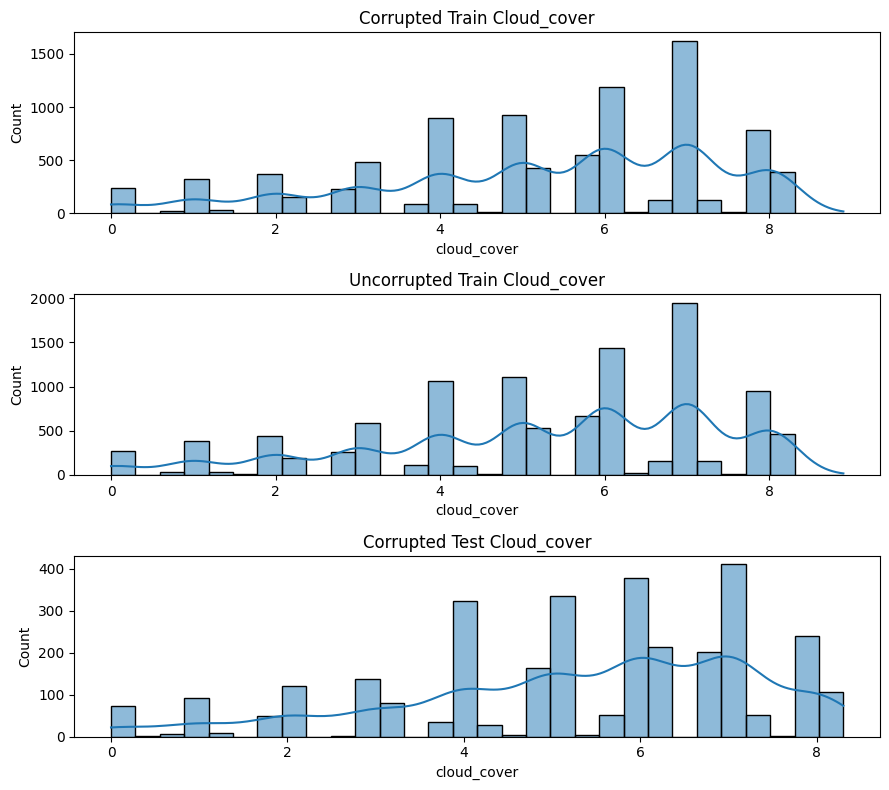

In [ ]:
plot_variable_histograms(corrupted_decades, uncorrupted_decades,test_df, 'cloud_cover', figsize=(9,8))
# multimodal disttrubtion

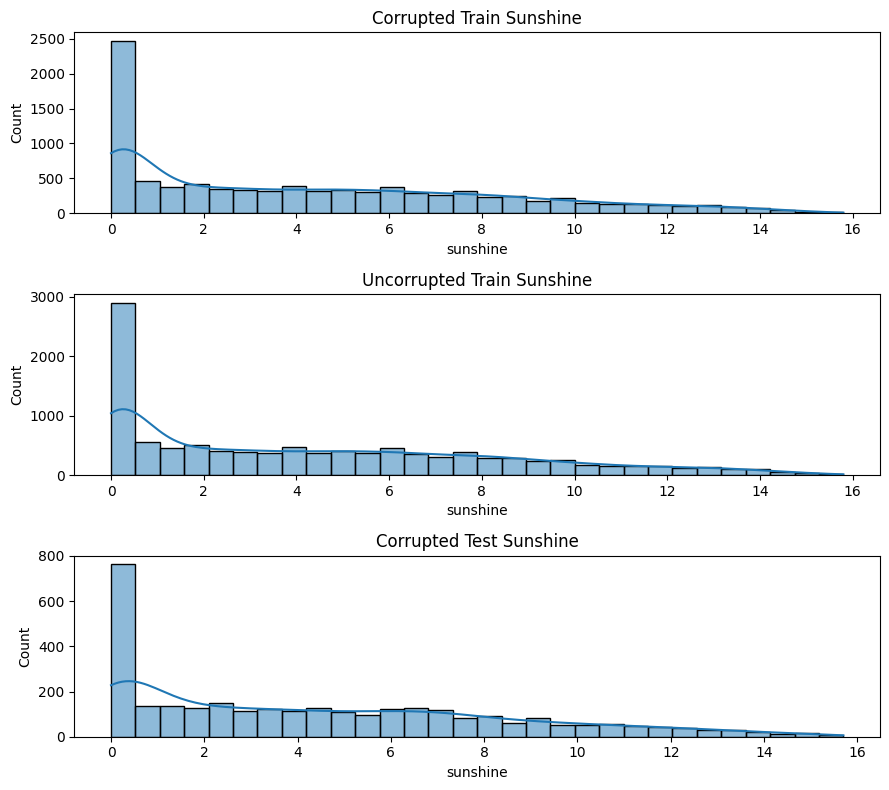

In [ ]:
plot_variable_histograms(corrupted_decades, uncorrupted_decades,test_df, 'sunshine', figsize=(9,8))
# Right Skewed Distribution

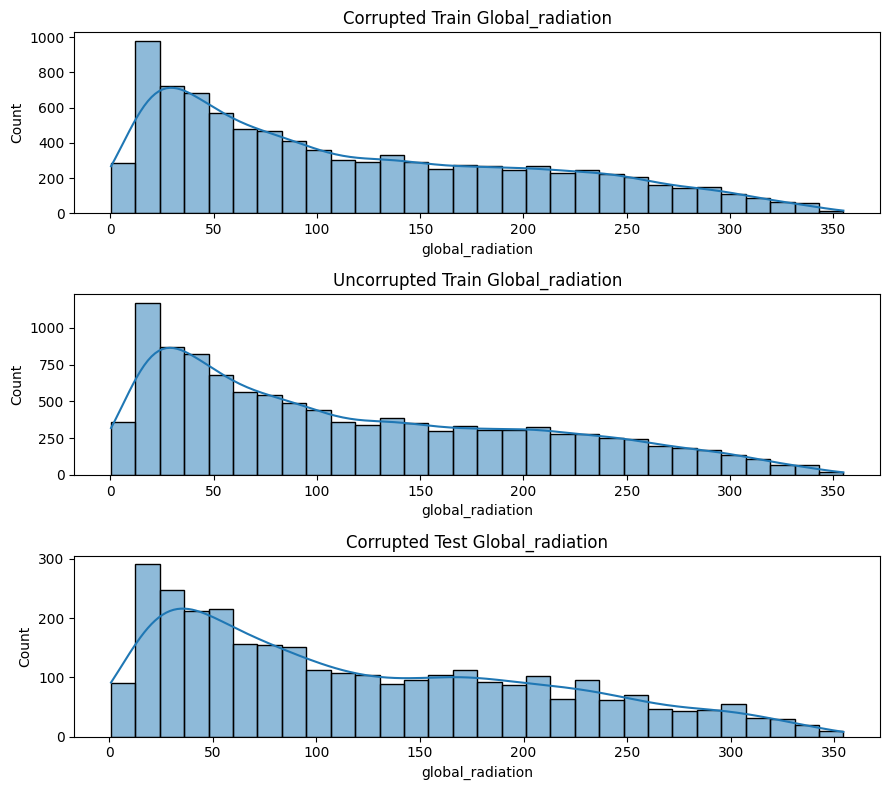

In [ ]:
plot_variable_histograms(corrupted_decades, uncorrupted_decades,test_df, 'global_radiation', figsize=(9,8))
# Right skewed Dsitrinbutio

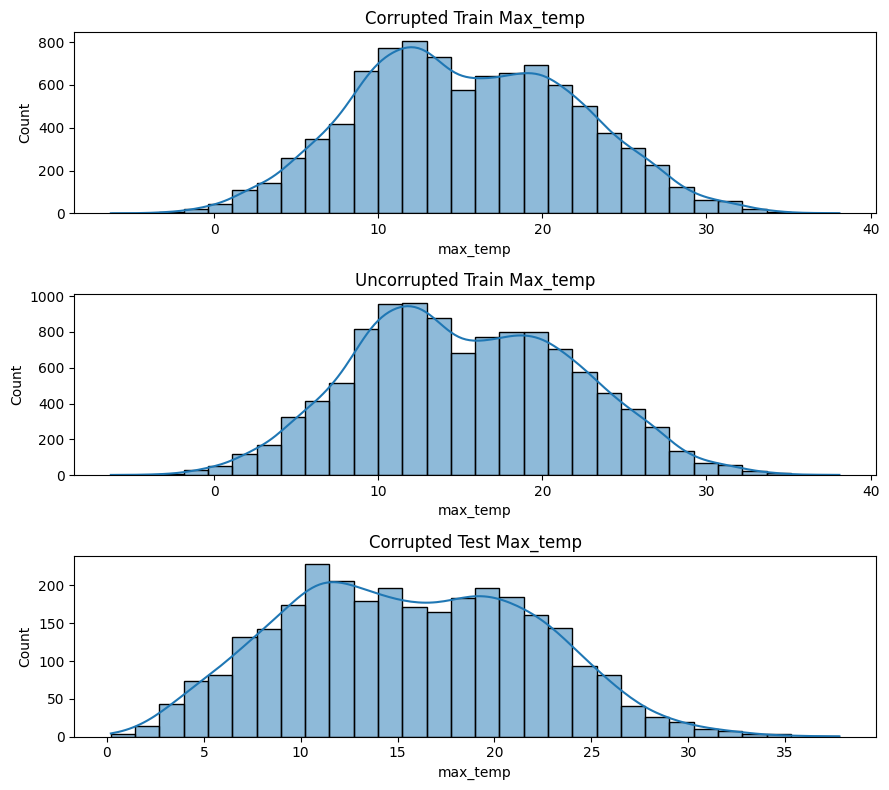

In [ ]:
plot_variable_histograms(corrupted_decades, uncorrupted_decades,test_df, 'max_temp', figsize=(9,8))
# Gaussian Distribution

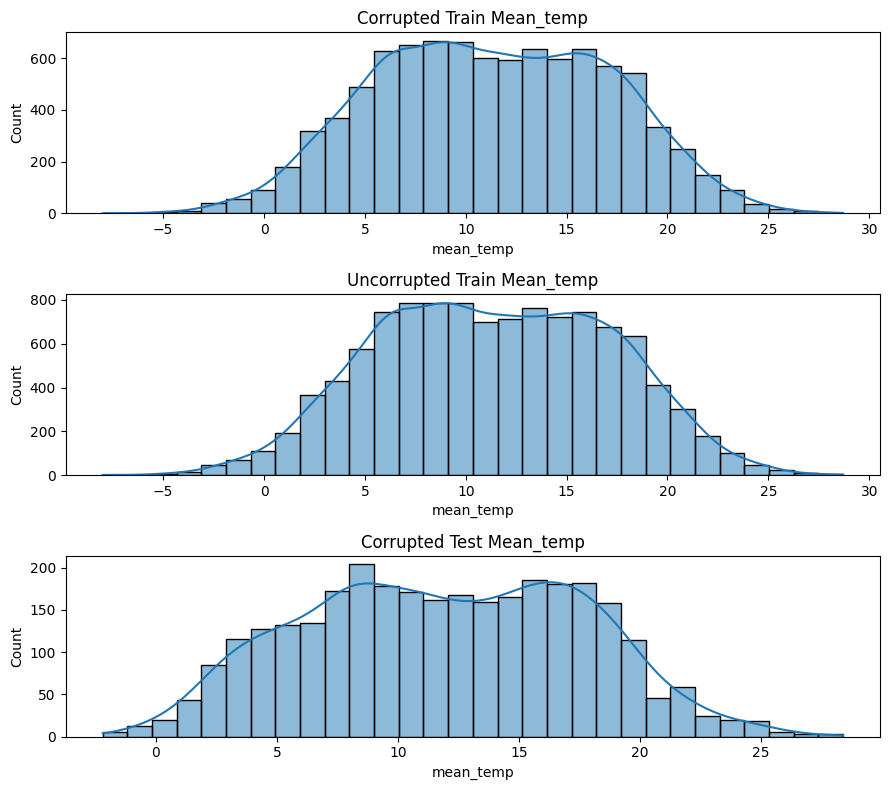

In [ ]:
plot_variable_histograms(corrupted_decades, uncorrupted_decades,test_df, 'mean_temp', figsize=(9,8))
# Gaussianm Distribution (central limit theorem)

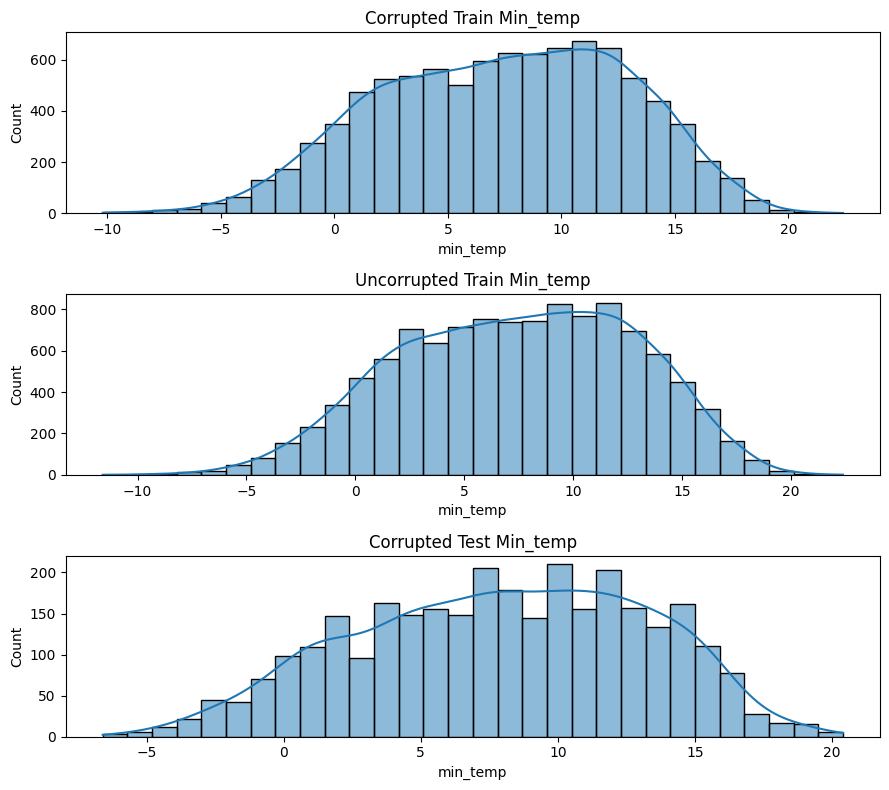

In [ ]:
plot_variable_histograms(corrupted_decades, uncorrupted_decades,test_df, 'min_temp', figsize=(9,8))
# Gaussian Distribtuin

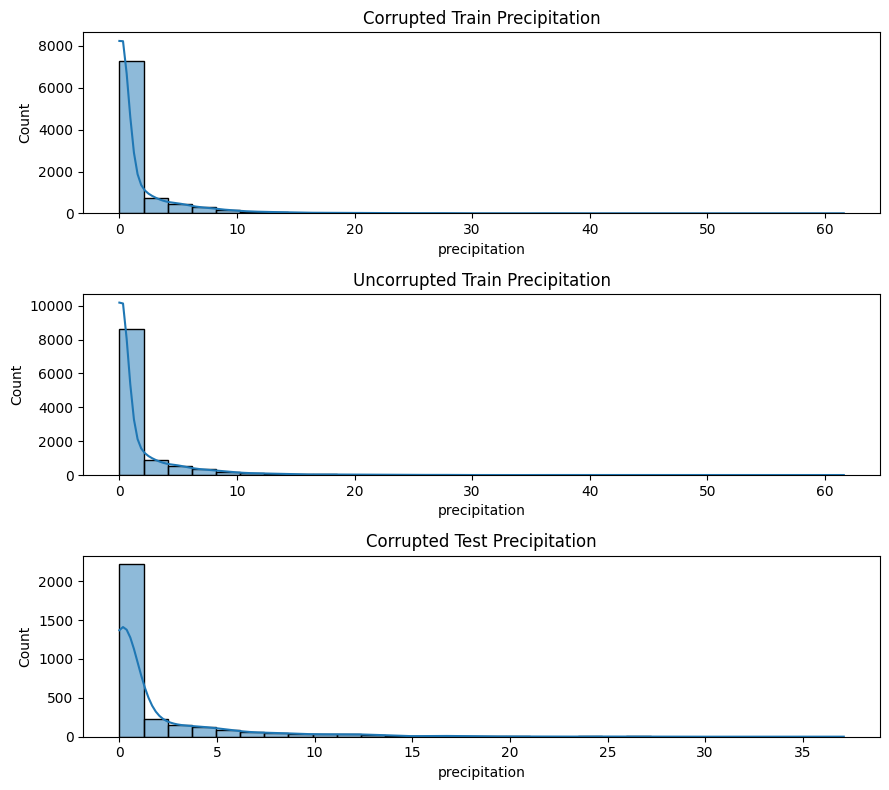

In [ ]:
plot_variable_histograms(corrupted_decades, uncorrupted_decades,test_df, 'precipitation', figsize=(9,8))
# Right skewed Distribution

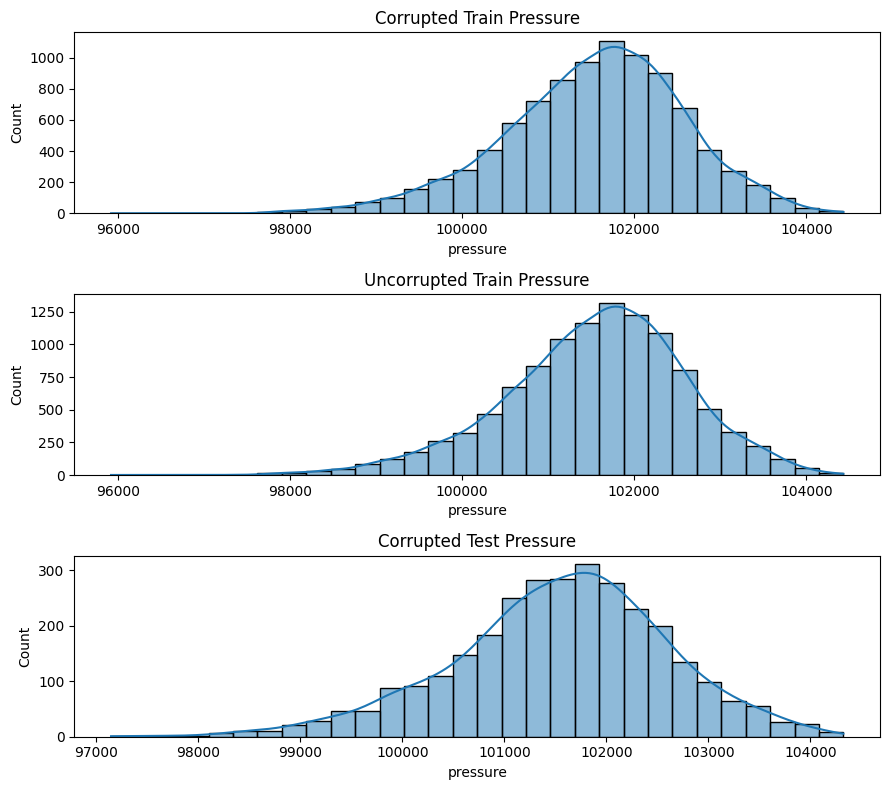

In [ ]:
plot_variable_histograms(corrupted_decades, uncorrupted_decades,test_df, 'pressure', figsize=(9,8))
# TBD

<br>

---

<br>

## **Question 2**  (25%)

Using the data loaded in **Question 1**, create a PyTorch `TensorDataset`, and create one `DataLoader` for the training set and another one for the test set.

The training loader should provide batches of weather data that have been corrupted, as well as the corresponding, paired un-corrupted batch of data. The test loader should provide batches of corrupted weather data, with no corresponding uncorrupted labels.

Using line plots, show here one batch from both the training and test datasets before and after corruption. Use different axis windows for input and label of the batch.

<br>



The initialization of this Dataset class required the most iterations and underwent many changes. We are trying to create a Dataset class that works for both the train and test sets. In fact, there is an optional variable uncorr_file that can be activated for the train set, as the test set has no targets (since we are predicting on it).

The first issue that arose was regarding the different CSV files. Since we are unaware of the chronological order among these three files and we are using sequential data, we must be extremely cautious. For example, if we decided to concatenate all three CSV files during training, our batch size (or even sequence length) could have taken values from both files, potentially causing us to jump from the 1980s-1990s to the 1960s-1970s, which is not tolerable. Therefore, I opted to create three different data loaders, each corresponding to one CSV file, and adjusted them accordingly when training the model [1].

One implementation that significantly improved my loss (which we will discuss in more detail later) was ZIMC [4] (Zero Impute Mask Concat). This technique relies on adding (concatenating) a mask of 0s and 1s to the input, indicating to the model where the missing values are precisely located in our input. This will, of course, alter the shape of the input, changing it from [batch_size, sequence_length, number_of_col (8)] to [batch_size, sequence_length, number_of_col, 16] as we are concatenating along dimension -1.


In [ ]:
class MaskedSequentialDataset2(Dataset):
  # Accept a single csv file (an optinal target_file)
    def __init__(self, file, uncorr_file=None, sequence_length=30,value_replacing_nan = 0):

        #  Data Prepreocssing using pandas (drop data column & normalize given mean and std)
        df = pd.read_csv(file).drop(columns='date')
        mean = df.mean()
        std = df.std()
        df_normalized = (df - mean) / std

        # Transformed to tensor
        self.data = torch.tensor(df_normalized.values, dtype=torch.float32)

        if uncorr_file:
            df_target = pd.read_csv(uncorr_file).drop(columns='date')
            mean = df_target.mean()
            std = df_target.std()
            df_normalized_target = (df_target - mean) / std
            self.target = torch.tensor(df_normalized_target.values, dtype=torch.float32)
        else:
            self.target = None

        self.sequence_length = sequence_length
        self.num_windows = self.data.shape[0] - sequence_length + 1
        self.value_replacing_nan = value_replacing_nan


    def __len__(self):
        return self.num_windows

    def __getitem__(self, index):
        # current sequence given an index
        sequence = self.data[index:index + self.sequence_length]
        # Create a boolean mask of True or False
        mask = torch.isnan(sequence)
        # Converts all nan to 0
        sequence = torch.nan_to_num(sequence, nan=self.value_replacing_nan)
        # Concat both mask and sequence
        sequence_and_mask = torch.cat([sequence, mask], dim=-1) # shape [batch_size, sequence_length ,16 ]

        if self.target is not None:
            sequence_target = self.target[index:index + self.sequence_length] # shape [batch_size, sequence_length  8 ]
            return sequence_and_mask, sequence_target
        else:
            return sequence_and_mask

In [ ]:
# Iniatiate and Create dataloader for all three train_datasets
train_dataset0 = MaskedSequentialDataset2(file= 'training_set_0.csv', uncorr_file = 'training_set_0_nogaps.csv')
train_dataset1 = MaskedSequentialDataset2(file= 'training_set_1.csv', uncorr_file = 'training_set_1_nogaps.csv')
train_dataset2 = MaskedSequentialDataset2(file= 'training_set_2.csv', uncorr_file = 'training_set_2_nogaps.csv')

train_loader0 = DataLoader(train_dataset0, batch_size=100, shuffle=False)
train_loader1 = DataLoader(train_dataset1, batch_size=100, shuffle=False)
train_loader2 = DataLoader(train_dataset2, batch_size=100, shuffle=False)

In [ ]:
# Iniatiate and Create dataloader for test_dataset
test_dataset = MaskedSequentialDataset2(file= 'test_set.csv')
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

In [ ]:
data, target = next(iter(train_loader0))
data.shape, target.shape

(torch.Size([100, 30, 16]), torch.Size([100, 30, 8]))

In a general manner, for illustration purposes, let's create a train_dataset where I replace all NaN values with -1000 (in reality, it is be 0 when hypertuning it). Then, I will replace all values equal to -1000 with NaN values, indicating that in the initial corrupted files, these were missing values. This is necessary because, in my Dataset, I am already converting all NaN values to a different representation.

In [ ]:
def replace_value_with_nan(data, value_to_replace):
    data_np = data.numpy()
    data_np[data_np == value_to_replace] = torch.nan
    return torch.tensor(data_np, dtype=torch.float32)

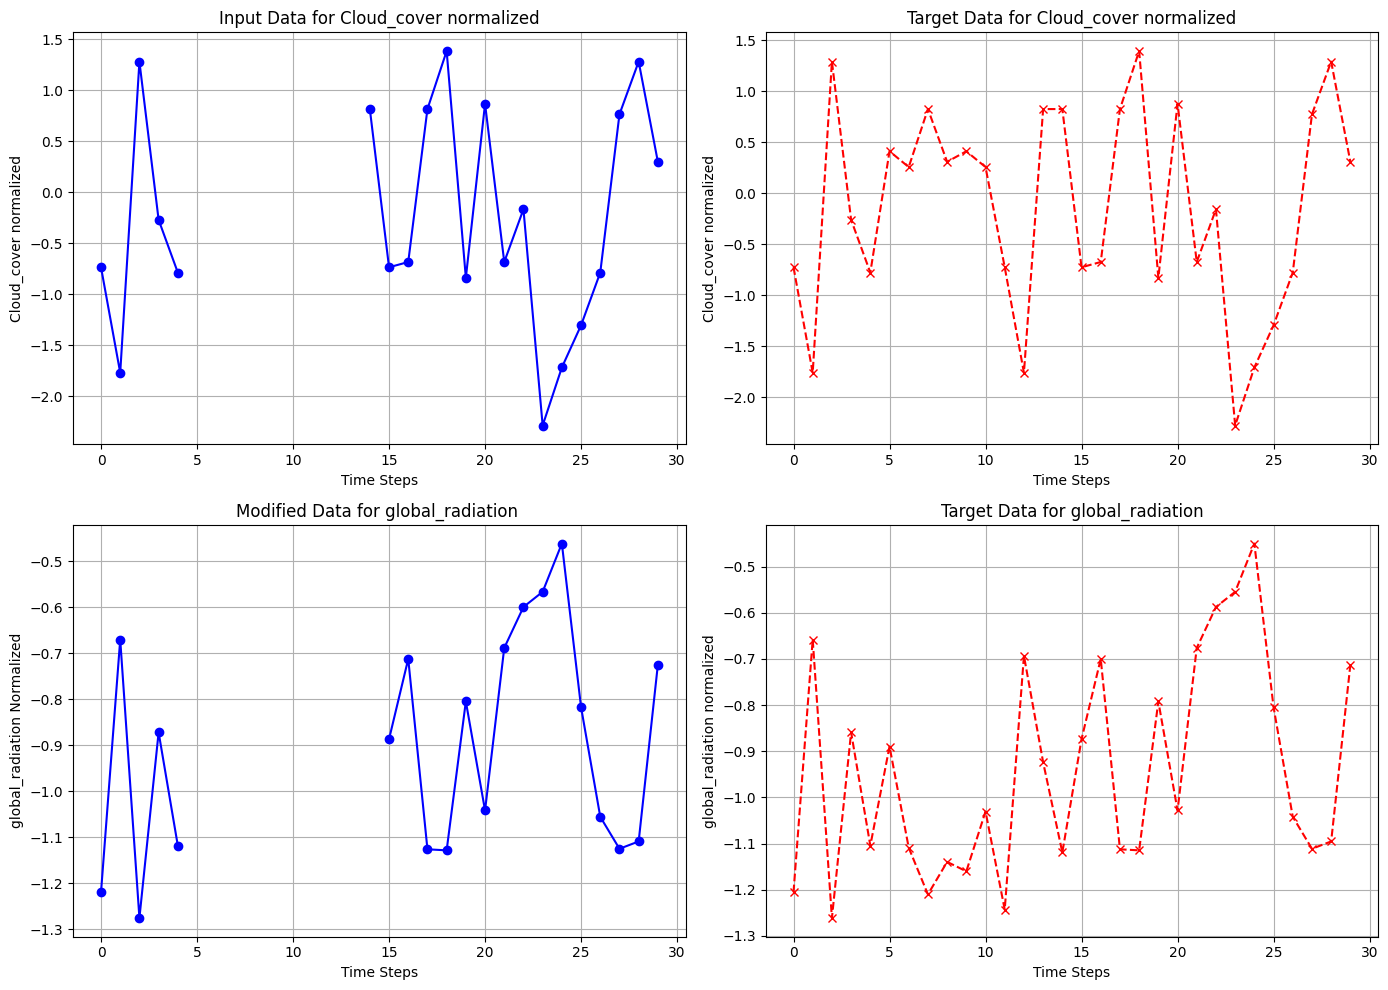

In [ ]:
example_train_dataset0 = MaskedSequentialDataset2(file= 'training_set_0.csv', uncorr_file = 'training_set_0_nogaps.csv',value_replacing_nan=-1000)
example_train_loader0 = DataLoader(example_train_dataset0, batch_size=100, shuffle=False)

input, target = next(iter(example_train_loader0))

input_1 = replace_value_with_nan(input[0, :, 0], -1000)
input_2 = replace_value_with_nan(input[0, :, 2], -1000)

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

axs[0,0].plot(input_1, marker='o', linestyle='-', color='b')
axs[0,0].set_title('Input Data for Cloud_cover normalized')
axs[0,0].set_xlabel('Time Steps')
axs[0,0].set_ylabel('Cloud_cover normalized')
axs[0,0].grid()

axs[0, 1].plot(target[0, :, 0], marker='x', linestyle='--', color='r')
axs[0, 1].set_title('Target Data for Cloud_cover normalized')
axs[0, 1].set_xlabel('Time Steps')
axs[0, 1].set_ylabel('Cloud_cover normalized')
axs[0, 1].grid()

axs[1, 0].plot(input_2, marker='o', linestyle='-', color='b')
axs[1, 0].set_title('Modified Data for global_radiation ')
axs[1, 0].set_xlabel('Time Steps')
axs[1, 0].set_ylabel('global_radiation Normalized')
axs[1, 0].grid()

axs[1, 1].plot(target[0, :, 2], marker='x', linestyle='--', color='r')
axs[1, 1].set_title('Target Data for global_radiation')
axs[1, 1].set_xlabel('Time Steps')
axs[1, 1].set_ylabel('global_radiation normalized')
axs[1, 1].grid()

plt.tight_layout()

plt.show()

torch.Size([100, 30, 16])


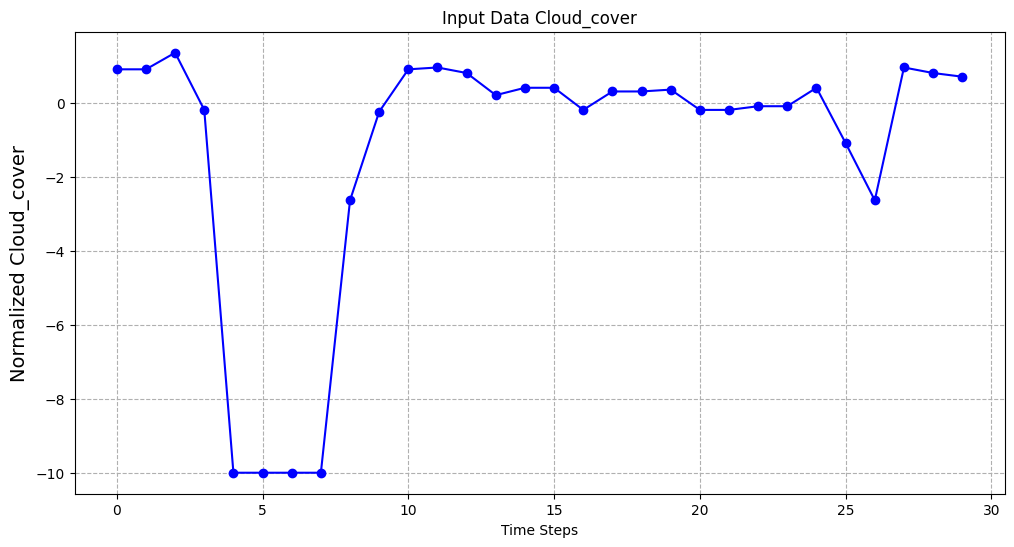

In [ ]:
# here when the value is at -10 it corresponds to a NaN
example_test_dataset = MaskedSequentialDataset2(file= 'test_set.csv',value_replacing_nan=-10)
example_test_loader = DataLoader(example_test_dataset, batch_size=100, shuffle=False)
input = next(iter(example_test_loader))
print(input.shape)
input = input[0, :, 0]
plt.figure(figsize=(12, 6))
plt.plot(input, marker='o', linestyle='-', color='b')
plt.title('Input Data Cloud_cover')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Cloud_cover', fontsize=14)

plt.grid(linestyle='--')

The graph below is just a visualization to demonstrate that our __getitem__ method works correctly. We can easily access an index of a random variable (here I chose the first column, which is cloud_cover). As seen in the graph, each iteration of the sequence length shifts one position to the right while maintaining the determined length of the sequence.

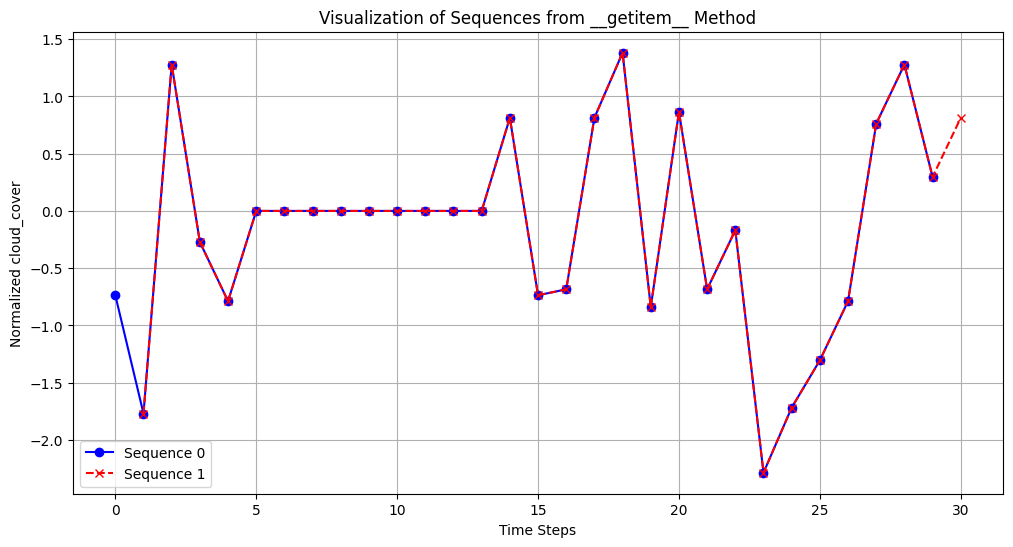

In [ ]:
plt.figure(figsize=(12, 6))

# First sequence at index 0
plt.plot(data[0, :, 0], marker='o', label='Sequence 0', linestyle='-', color='b')

# Second sequence at index 1
plt.plot(range(1, len(data[1, :, 0]) + 1), data[1, :, 0], marker='x', label='Sequence 1', linestyle='--', color='r')

plt.title('Visualization of Sequences from __getitem__ Method')
plt.xlabel('Time Steps')
plt.ylabel('Normalized cloud_cover')
plt.legend()

plt.grid()

<br>

---

<br>

## **Question 3** (50%)

Using the dataset created in **Question 2**, design and train an architecture to recover the missing weather values of the provided test dataset.

Using line plots, show the test weather data with the missing values filled in using a different colour.

Additionally, save the test data with the missing values filled in into a file called `test_set_nogaps.csv` inside this repository. This file should have the same format as the original `test_set.csv` file, with the same number of rows and columns, the same row and column ordering, and the same column headings.

You have freedom to choose an architecture that you consider appropriate to solve this problem. However, you will need to train your chosen architecture as part of the assessment: **pre-trained networks are not allowed**.

You will be assessed by the quality of your predictions of the missing data values and additional marks will be given for originality in your network design choices. You should include, as part of your answer, a paragraph explaining the architecture you have chosen and any additional design choices and hyperparameters that have been important to build your solution.

This is an open-book assessment and you are encouraged to use resources online, including  tools like chatGPT. However, make sure to always mention the sources for your code and ideas, including websites, papers, and tools like chatGPT.

<br>


---
**Question 3 answers**

When reviewing the literature, I found multiple articles indicating that LSTM (Long Short-Term Memory) models are particularly suitable for tasks involving missing data in weather prediction. "LSTM, an essentially improved extension of RNNs, excels in interpreting long time series of historical data" [5].

Therefore, as practice encourages, I started with a simple LSTM, which immediately yielded convincing results. Further literature reviews revealed that many papers corroborated the effectiveness of bidirectional LSTMs for this task as well [6]. By 'bidirectional,' I mean that this approach enables the LSTM to have two hidden states for each time step: one processing the sequence in the forward direction and the other in the backward direction. This allows the model to capture information from both past and future states, resulting in a decrease in loss and improved clarity when plotting the reconstruction of missing values.

My model takes three parameters:

1.   Input size: 16, due to the mask explained above.
2.   Hidden size (hyperparameter): This represents the number of features in the hidden state of the LSTM; I used 128.
3. Output size: 8.



In [95]:
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BiLSTM, self).__init__()
        self.bilstm = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)
        # the hidden_size is multiplied by 2 because of bidirectional LSTM (one for each direction)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        lstm_out, _ = self.bilstm(x)
        output = self.fc(lstm_out)

        return output

In [ ]:
def train_model(model, train_loader, criterion, optimizer, device, target_size):
    model.train()
    train_loss = 0.0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        context, mask = inputs[:, :-target_size], inputs[:, -target_size:]

        valid_mask = (targets != 0).float()

        outputs_masked = outputs * valid_mask
        targets_masked = targets * valid_mask

        loss = criterion(outputs_masked, targets_masked)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    return train_loss / len(train_loader)

In [ ]:
def validate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    return val_loss / len(val_loader)

In [ ]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

Once the dataset and dataloader were completed, the next critical step was hypertuning. I needed to train my model while monitoring the loss, which was the Mean Squared Error (MSE) — a suitable metric for regression tasks.

To begin, I split my train_set into training and validation subsets using an 80/20 ratio. Importantly, the validation set consisted of the last 20% of values in the train_set, as is common practice with sequential data. This ensures the temporal order is preserved, so shuffle was set to False.

Since I used three dataloaders (one for each decade), I had to train and evaluate my model appropriately. For each epoch, all three training and validation loaders were passed through the model. The mean of the three train losses and validation losses was calculated to obtain the final loss for that epoch.

A systematic trial-and-error approach was employed to find the best model parameters. Below is a non-exhaustive list of the parameters I adjusted during this process:


*   **Optimizer**: I tested both Adam and AdamW. As the saying goes, "the answer is always Adam," and indeed, Adam performed better in this case.
*   Hidden size: Adjusted the number of neurons in hidden layers.
*   Weight decay: Tuned to control overfitting.
*   Batch size: Experimented with different sizes for better generalization.
*   Sequence length: Explored varying lengths for the input sequences.
*  Number of epochs: Limited the epochs to avoid overfitting.

One significant challenge I encountered was rapid overfitting. To mitigate this, I limited the number of epochs to 10. I also attempted to add dropout to the LSTM layers, but this unexpectedly worsened the results. Switching the loss function to Mean Absolute Error (MAE), which is also suitable for regression tasks, did not improve the outcome.

If I had more time, I would have considered:

*   Exploring advanced architectures such as Transformers
*   Increasing the complexity of my model architecture by adding more layers.




In [99]:
input_size = 16
hidden_size = 128
output_size = 8
num_epochs = 10
batch_size = 32

# load and train_val split
def load_and_split_data(file_path, label_path, split_ratio=0.8):
    dataset = MaskedSequentialDataset2(file_path, label_path)
    split_index = int(len(dataset) * split_ratio)
    train_subset = torch.utils.data.Subset(dataset, range(0, split_index))
    val_subset = torch.utils.data.Subset(dataset, range(split_index, len(dataset)))
    return (DataLoader(train_subset, batch_size=batch_size, shuffle=False),
            DataLoader(val_subset, batch_size=batch_size, shuffle=False))
train_loader0, val_loader0 = load_and_split_data('training_set_0.csv', 'training_set_0_nogaps.csv')
train_loader1, val_loader1 = load_and_split_data('training_set_1.csv', 'training_set_1_nogaps.csv')
train_loader2, val_loader2 = load_and_split_data('training_set_2.csv', 'training_set_2_nogaps.csv')

# Initialize model, loss function, and optimizer
model = BiLSTM(input_size, hidden_size, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    total_val_loss = 0.0

    for train_loader in [train_loader0, train_loader1, train_loader2]:
        train_loss = train_model(model, train_loader, criterion, optimizer, device, output_size)
        total_train_loss += train_loss

    for val_loader in [val_loader0, val_loader1, val_loader2]:
        val_loss = validate_model(model, val_loader, criterion, device)
        total_val_loss += val_loss

    # Average losses across all datasets
    avg_train_loss = total_train_loss / 3
    avg_val_loss = total_val_loss / 3

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.6f}, Validation Loss: {avg_val_loss:.6f}")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Epoch 1/10, Train Loss: 0.260786, Validation Loss: 0.114654
Epoch 2/10, Train Loss: 0.101052, Validation Loss: 0.090072
Epoch 3/10, Train Loss: 0.084087, Validation Loss: 0.078876
Epoch 4/10, Train Loss: 0.073380, Validation Loss: 0.070624
Epoch 5/10, Train Loss: 0.066417, Validation Loss: 0.065971
Epoch 6/10, Train Loss: 0.061147, Validation Loss: 0.062057
Epoch 7/10, Train Loss: 0.057007, Validation Loss: 0.059714
Epoch 8/10, Train Loss: 0.053760, Validation Loss: 0.057708
Epoch 9/10, Train Loss: 0.051068, Validation Loss: 0.057379
Epoch 10/10, Train Loss: 0.047061, Validation Loss: 0.055687


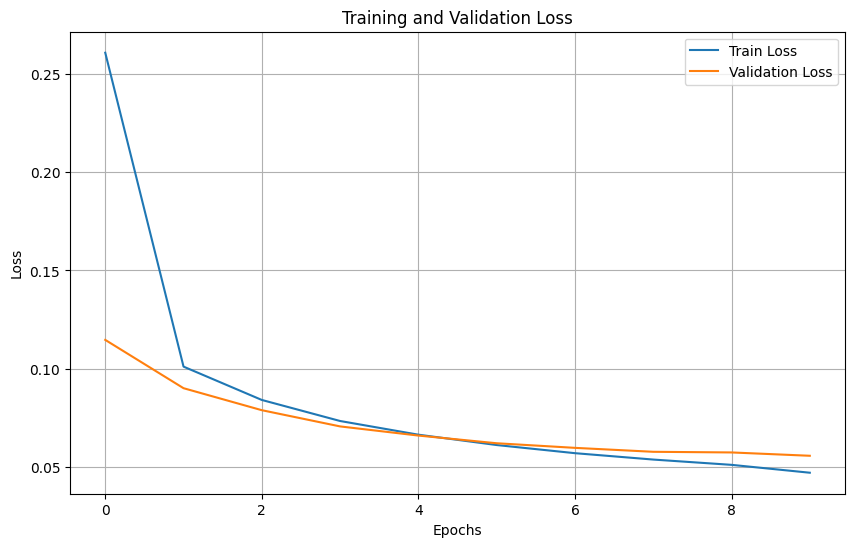

In [100]:
# potential overifitting
plot_losses(train_losses, val_losses)

An example of a variable present in the train_loader is cloud_cover, which had both corrupted and uncorrupted values. I used my model as an imputer to predict the missing values for the corrupted data. The results were satisfactory, with the predictions closely matching the uncorrupted values.


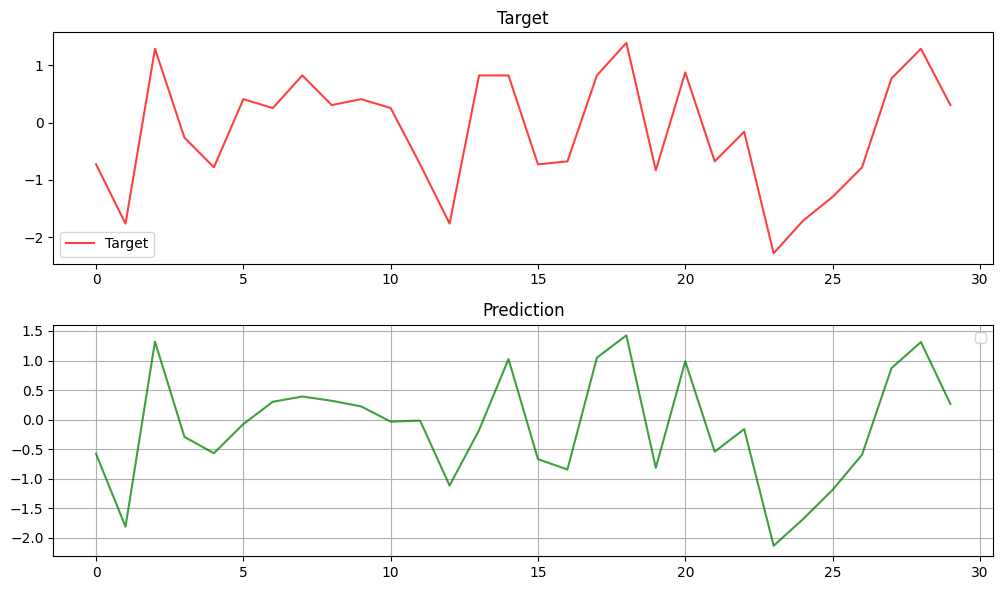

In [110]:
import numpy as np

model.eval()

original_values = []
labels = []
predictions = []

with torch.no_grad():
    for data in train_loader0:
        inputs, targets = data

        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
        input = inputs[0,:,0].cpu().numpy()
        target = targets[0,:,0].cpu().numpy()
        output = outputs[0,:,0].cpu().numpy()
        break

input[input == 0] = np.nan

fig, axs = plt.subplots(2, 1, figsize=(10, 6))


axs[0].grid()

axs[0].plot(target, label='Target', color='red', alpha=0.75)
axs[0].set_title('Target')

axs[0].legend()
axs[0].grid()

axs[1].plot(output, color='green', alpha=0.75)
axs[1].set_title('Prediction')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()


Predict the missing values in test_set using my model

In [78]:
df = pd.read_csv('/content/test_set.csv').drop(columns='date')
df.head(10)

means= df.mean()
stds = df.std()

In [79]:
model.eval()

all_predictions = []

with torch.no_grad():
    for inputs in test_loader:
        inputs = inputs.to(device)

        outputs = model(inputs)

        outputs_np = outputs.cpu().numpy()

        for output in outputs_np:
            unnormalized_output = output * stds.values + means.values
            all_predictions.append(unnormalized_output)

all_predictions = np.concatenate(all_predictions, axis=0)

df_predictions = pd.DataFrame(all_predictions, columns=['cloud_cover', 'sunshine', 'global_radiation', 'max_temp', 'mean_temp', 'min_temp', 'precipitation', 'pressure'])

df_predictions.head()


,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure
0,7.463615,-0.127292,19.689767,10.737589,7.556475,4.632982,-0.118520,102455.204291
1,7.523118,0.106222,16.931971,10.795725,7.725573,5.342679,-0.209446,102586.642849
2,8.427380,-0.372253,11.594668,9.092528,9.062840,7.671678,5.730871,101769.576390
3,5.022200,2.347825,31.949775,10.705739,6.199422,3.835504,-0.166461,101462.889527
4,6.271910,1.193081,23.432778,10.001337,5.847974,1.403172,0.692525,101534.184557


In [80]:
df_final = df.fillna(df_predictions).round(1)
df_final.head(10)

,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure
0,7.1,0.5,15.5,11.1,7.4,4.6,0.0,102472.1
1,7.1,0.8,19.4,11.0,7.7,5.2,0.0,102547.2
2,8.0,0.0,8.8,9.3,9.2,7.6,6.1,101847.4
3,4.9,2.6,30.8,11.6,6.9,4.3,0.0,101370.4
4,6.3,2.0,25.0,10.5,6.1,1.9,0.7,101383.3
5,6.8,0.3,20.4,11.1,8.5,6.9,-0.0,101239.0
6,5.9,2.0,35.7,9.3,6.8,2.6,2.1,101671.1
7,4.2,6.5,51.8,7.4,7.8,6.0,0.1,101638.4
8,0.0,7.3,58.3,8.1,2.9,-0.7,0.1,102641.9
9,4.8,3.7,37.8,10.1,1.7,-3.0,-0.0,103502.8


In [ ]:
df_final.to_csv('/content/drive/MyDrive/df_final.csv', index=False)

In [ ]:
pd.read_csv('/content/drive/MyDrive/df_final.csv')

,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure
0,7.1,0.5,15.5,11.1,7.4,4.6,0.0,102472.1
1,7.1,0.8,19.4,11.0,7.7,5.2,0.0,102547.2
2,8.0,0.0,8.8,9.3,9.2,7.6,6.1,101847.4
3,4.9,2.6,30.8,11.6,6.9,4.3,0.0,101370.4
4,6.2,2.0,25.0,10.5,6.1,1.9,0.7,101383.3
...,...,...,...,...,...,...,...,...
3647,4.1,1.6,32.2,7.8,11.1,2.0,0.2,100024.1
3648,2.0,1.9,24.1,5.3,11.7,4.8,0.0,99900.1
3649,2.2,3.8,34.4,4.8,9.5,-2.3,0.7,100411.3
3650,7.9,0.0,7.5,5.1,12.4,-1.0,12.7,99516.7


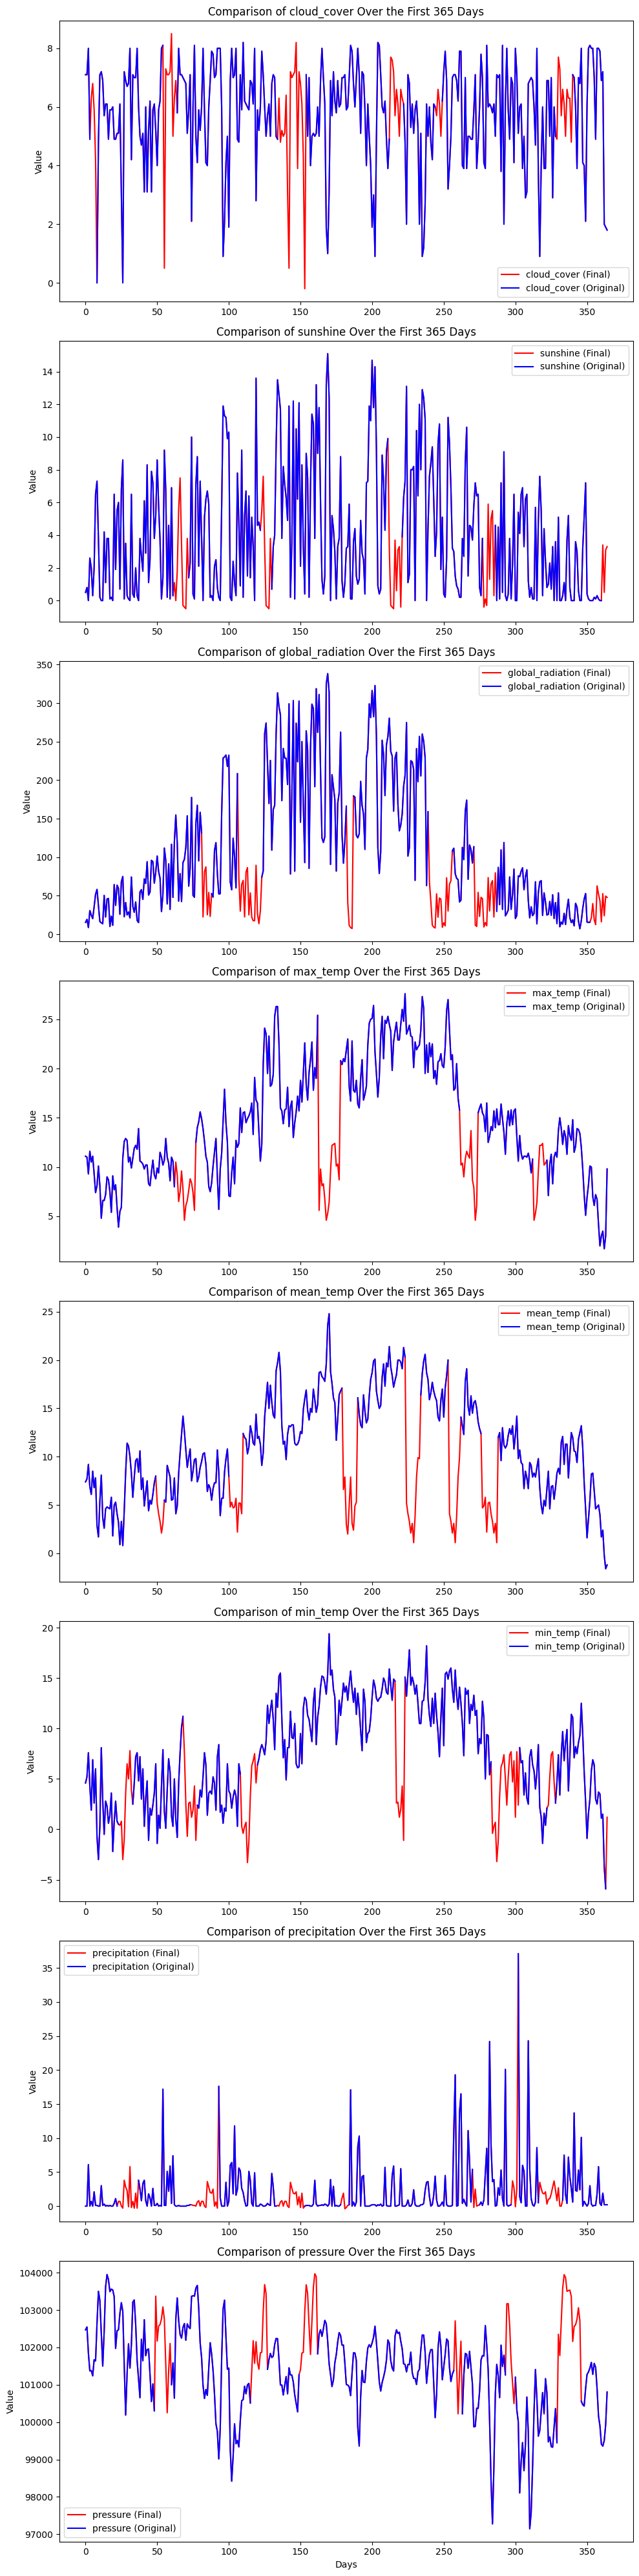

In [108]:
variables_to_plot = df_final.columns

num_vars = len(variables_to_plot)

fig, axs = plt.subplots(num_vars, 1, figsize=(10, 5 * num_vars))

for i, variable in enumerate(variables_to_plot):
    axs[i].plot(df_final[variable][:365], color='red', label=f'{variable} (Final)')
    axs[i].plot(df[variable][:365], color='blue', label=f'{variable} (Original)')
    axs[i].set_title(f'Comparison of {variable} Over the First 365 Days')
    axs[i].set_ylabel('Value')
    axs[i].legend()

axs[-1].set_xlabel('Days')

plt.tight_layout()
plt.show()